*David Schlangen, 2019-03-25*

# Task: Generating Referring Expressions

The task of *generating* referring expressions has been of central interest in the field of natural language generation for a long time (see recent survey in \cite{KrahmerDeemter:REGsurvey}). However, only recently has work started to look at visually (rather than symbolically) represented reference targets (\cite{Kazemzadeh2014}, \cite{Maoetal:cocorefexp_Final}, \cite{Zarriess2016}, \cite{zarriess:inlg18}).

It is clear that here context is important and it is not enough to generate a true description; the description must also uniquely single out the referent, for the given addressee.

In [1]:
# imports

import configparser
import os
import random
from textwrap import fill
import sys

import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from IPython.display import Latex, display

pd.set_option('max_colwidth', 250)

In [2]:
# Load up config file (needs path; adapt env var if necessary); local imports

# load config file, set up paths, make project-specific imports
config_path = os.environ.get('VISCONF')
if not config_path:
    # try default location, if not in environment
    default_path_to_config = '../../clp-vision/Config/default.cfg'
    if os.path.isfile(default_path_to_config):
        config_path = default_path_to_config

assert config_path is not None, 'You need to specify the path to the config file via environment variable VISCONF.'        

config = configparser.ConfigParser()
with open(config_path, 'r', encoding='utf-8') as f:
    config.read_file(f)

corpora_base = config.get('DEFAULT', 'corpora_base')
preproc_path = config.get('DSGV-PATHS', 'preproc_path')
dsgv_home = config.get('DSGV-PATHS', 'dsgv_home')


sys.path.append(dsgv_home + '/Utils')
from utils import icorpus_code, plot_labelled_bb, get_image_filename, query_by_id
from utils import plot_img_cropped, plot_img_ax, invert_dict, get_a_by_b
sys.path.append(dsgv_home + '/WACs/WAC_Utils')
from wac_utils import create_word2den, is_relational
sys.path.append(dsgv_home + '/Preproc')
from sim_preproc import load_imsim, n_most_sim

sys.path.append('../Common')
from data_utils import load_dfs, plot_rel_by_relid, get_obj_bb, compute_distance_objs
from data_utils import get_obj_key, compute_relpos_relargs_row, get_all_predicate
from data_utils import compute_distance_relargs_row, get_rel_type, get_rel_instances
from data_utils import compute_obj_sizes_row

In [3]:
# Load up preprocessed DataFrames. Slow!
# These DataFrames are the result of pre-processing the original corpus data,
# as per dsg-vision/Preprocessing/preproc.py

df_names = [#'saiapr_bbdf', 'saiapr_refdf',
            'mscoco_bbdf', 'refcoco_refdf', 'refcocoplus_refdf', 'grex_refdf']
            # 'vgregdf', 'vgimgdf', 'vgobjdf', 'vgreldf',
            # 'vgpardf', 'cococapdf']
            # 'flickr_bbdf', 'flickr_capdf', 'flickr_objdf']
df = load_dfs(preproc_path, df_names)

We have discussed referring expressions already in the denotations notebook, from the perspective of interpretation. In a way, interpretation is the easier task -- given the assumption that the expression is indeed intended to single out one object, one can go where the utterance leads. But in generating the utterance, the path for the addressee to follow must be constructed. We can try to use the referring expression corpora to learn how to do so.

Here is an example from RefCoco:

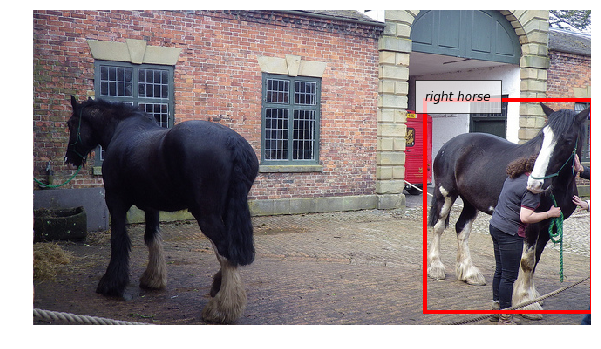

In [4]:
# plot refexp on one of the objects
pick_row = 1234
ic, ii  = df['refcoco_refdf'].iloc[pick_row][['i_corpus', 'image_id']]

ri = query_by_id(df['mscoco_bbdf'], (ic, ii), 'region_id')[1]
refexp = query_by_id(df['refcoco_refdf'], (ic, ii, ri), 'refexp')[0]
bb = query_by_id(df['mscoco_bbdf'], (ic, ii, ri), 'bb')[0]
plot_labelled_bb(get_image_filename(config, ic, ii), [(bb, refexp)])

* **Dataset:** referring expressions (mostly NPs)
* **Negative Instances:** negative sampling, from other objects in image (or from other images)
* **Source:** ReferIt, RefCoco, RefCoco+, GoogleRex
* **Uses:** evaluate (or tune) composition function; can also be used to learn interpretation function of constituent words

Besides training an end-to-end model and hoping that it does the right thing, we can use the data to try to rationally reconstruct principles followed by the speakers. (Remember that we have both information about the referring expression that people used successfully to refer to a given object, as well as category information from a closed and disjunct set of categories.)

Questions to ask for example are the following: What makes it possible to refer with only a one-word utterance? What makes longer utterances necessary? The "rational speech act model" \cite{frankgoodman:rsa} makes certain predictions about how speakers chose their utterances. Can it predict the expressions used here?

# References

[<a id="cit-KrahmerDeemter:REGsurvey" href="#call-KrahmerDeemter:REGsurvey">1</a>] Krahmer Emiel and van Deemter Kees, ``_Computational Generation of Referring Expressions : A Survey_'', CL, vol. 38, number 1, pp. ,  2012.

[<a id="cit-Kazemzadeh2014" href="#call-Kazemzadeh2014">2</a>] S. Kazemzadeh, V. Ordonez, M. Matten <em>et al.</em>, ``_ReferItGame: Referring to Objects in Photographs of Natural Scenes_'', Proceedings of the Conference on Empirical Methods in Natural Language Processing (EMNLP 2014),  2014.

[<a id="cit-Maoetal:cocorefexp_Final" href="#call-Maoetal:cocorefexp_Final">3</a>] J. Mao, ``_Generation and Comprehension of Unambiguous Object Descriptions_'', Proceedings of CVPR 2016, June 2016.

[<a id="cit-Zarriess2016" href="#call-Zarriess2016">4</a>] S. Zarrie{\ss} and D. Schlangen, ``_Easy things first: Installments improve referring expression generation for objects in photographs_'', 54th Annual Meeting of the Association for Computational Linguistics, ACL 2016 - Long Papers,  2016.

[<a id="cit-zarriess:inlg18" href="#call-zarriess:inlg18">5</a>] S. Zarrieß and D. Schlangen, ``_Decoding Strategies for Neural Referring Expression Generation_'', Proceedings of the International Conference on Natural Language Generation (INLG),  2018.

[<a id="cit-frankgoodman:rsa" href="#call-frankgoodman:rsa">6</a>] Frank Michael C and Goodman Noah D, ``_Predicting pragmatic reasoning in language games._'', Science, vol. 336, number 6084, pp. 998, may 2012.  [online](http://www.ncbi.nlm.nih.gov/pubmed/22628647)

